# Project: Maharashtra Digital Demographics & Migration Analysis

## 1. Objective
To detect and quantify the "Great Migration" within Maharashtra by analyzing the disparity between **Child Enrolments (0-5 Years)** and **Adult Workforce Activity (18+ Years)**. The goal is to mathematically prove the labor flow from the agrarian "Sugar Belt" (Marathwada/Vidarbha) into the industrial "Golden Triangle" (Mumbai-Pune-Thane) using purely administrative data.

## 2. Methodology

**Data Sources:** Utilized two primary datasets:
 * 1. **Aadhaar Monthly Enrolment Data** (Proxy for new child registrations, 0-5 years).
 * 2. **Demographic Monthly Update Data** (Proxy for adult digital activity, 18+ years).

* **Data Cleaning (Crucial Step):** The raw dataset contained **48 entries** for 36 districts due to inconsistent naming (e.g., `MUMBAI SUB URBAN` vs `MUMBAI`) and recent official renamings (e.g., `AURANGABAD` → `CHHATRAPATI SAMBHAJINAGAR`). I implemented a "Nuclear Cleaning" map to merge these duplicates and standardize the "Renaming Effect," ensuring accurate district-level analysis.
* **Feature Engineering:** Developed a **"Migration Pressure Index"** (Children Enrolled per 1,000 Adult Workforce) to quantify the ratio of dependents to the active workforce.

## 3. Key Visualizations & Insights

### **A. Workforce Distribution (Pie Chart)**
* **Visualization:** A breakdown of the Total Adult Workforce (Enrolment + Updates) across the state.
* **Insight:** Highlights the extreme centralization of Maharashtra's economy, where the "Golden Triangle" (Mumbai, Pune, Thane) dominates the digital footprint compared to the long tail of 30+ agrarian districts.

### **B. The "Sugar & Tech" Divide (Scatter Plot)**
* **Visualization:** A correlation plot comparing *Child Enrolment* (Y-axis) vs. *Adult Workforce* (X-axis).
* **Insight:** The chart reveals a massive economic chasm.
    * **Industrial Hubs:** Pune and Mumbai show high adult density but lower relative child ratios, confirming they are labor importers.
    * **Agrarian Sources:** Districts in the "Sugar Belt" (Beed, Nanded) show the opposite trend, indicating families remaining behind while the workforce migrates.

### **C. The Migration Report Card (Lollipop Chart)**
* **Visualization:** A ranked analysis of the Migration Pressure Index.
* **Insight (The "Renaming Anomaly" & The Real Exodus):**
    * **The Anomaly:** **Chhatrapati Sambhajinagar** and **Dharashiv** show artificially low indices (high adult activity) driven by a surge in demographic updates due to their recent name changes.
    * **The Real Source:** **Nandurbar** and **Dhule** emerge as the true "Source Districts" with the highest Migration Pressure Indices (>200), confirming a massive net outflow of working-age adults.

## 4. Conclusion
The analysis confirms that Maharashtra operates as a "Dual Economy." While the Golden Triangle absorbs the workforce, the "renaming" of districts created a unique digital anomaly in Marathwada. Adjusting for this, the data proves a consistent migration trajectory from North Maharashtra (Nandurbar) into the industrial centers.

In [16]:
import pandas as pd
import regex as re

file_enrol = 'enrolment_mh.csv'  # Make sure your file is named this
file_update = 'update_mh.csv'    # Make sure your file is named this

def clean_basic(name):
    name = str(name).upper().strip()
    name = re.sub(r'[^A-Z\s]', '', name).strip()
    return name

try:
    cols_e = pd.read_csv(file_enrol, nrows=0).columns.tolist()
    col_dist_e = [c for c in cols_e if 'district' in c.lower()][0]

    cols_u = pd.read_csv(file_update, nrows=0).columns.tolist()
    col_dist_u = [c for c in cols_u if 'district' in c.lower()][0]

    dists_e = set(pd.read_csv(file_enrol, usecols=[col_dist_e])[col_dist_e].apply(clean_basic))
    dists_u = set(pd.read_csv(file_update, usecols=[col_dist_u])[col_dist_u].apply(clean_basic))

    only_in_enrol = dists_e - dists_u
    only_in_update = dists_u - dists_e

    common = dists_e.intersection(dists_u)

    print(f"Total Districts Identified: {len(common)}")
    print("-" * 30)
    print(f"MISMATCHES (Fix these in the next step):")
    print(f"In Enrolment but NOT Update: {only_in_enrol}")
    print(f"In Update but NOT Enrolment: {only_in_update}")

except Exception as e:
    print(f"[ERROR] {e}")

Total Districts Identified: 48
------------------------------
MISMATCHES (Fix these in the next step):
In Enrolment but NOT Update: {'AHMEDNAGAR'}
In Update but NOT Enrolment: {'DIST  THANE'}


In [15]:
mh_fix_map = {
    'DIST THANE': 'THANE', 'DIST  THANE': 'THANE', 'THANE RURAL': 'THANE',
    'MUMBAI SUBURBAN': 'MUMBAI', 'MUMBAI CITY': 'MUMBAI', 'MUMBAI SUB': 'MUMBAI',
    'AURANGABAD': 'CHHATRAPATI SAMBHAJINAGAR', 'SAMBHAJINAGAR': 'CHHATRAPATI SAMBHAJINAGAR',
    'OSMANABAD': 'DHARASHIV', 'RAIGARH': 'RAIGAD',
    'AHMEDNAGAR': 'AHILYANAGAR', 'AHMADNAGAR': 'AHILYANAGAR',
    'BEED': 'BID', 'BULDHANA': 'BULDANA', 'GONDIA': 'GONDIYA'
}

def clean_name(name):
    name = str(name).upper().strip()
    name = name.replace('DIST ', '').replace('DIST.', '').strip()
    name = re.sub(r'[^A-Z\s]', '', name).strip()
    return name

try:
    cols = pd.read_csv(file_enrol, nrows=0).columns.tolist()
    col_dist_e = [c for c in cols if 'district' in c.lower()][0]
    col_kids = [c for c in cols if '0_5' in c][0]
    col_adult_new = [c for c in cols if '18' in c and '5_18' not in c and '0_5' not in c][0]

    df_e = pd.read_csv(file_enrol, usecols=[col_dist_e, col_kids, col_adult_new])
    df_e['clean_dist'] = df_e[col_dist_e].apply(clean_name).replace(mh_fix_map)
    df_e_grouped = df_e.groupby('clean_dist')[[col_kids, col_adult_new]].sum().reset_index()
    df_e_grouped.rename(columns={col_kids: 'Child_Enrolment', col_adult_new: 'Adult_Enrolment'}, inplace=True)

    cols = pd.read_csv(file_update, nrows=0).columns.tolist()
    col_dist_u = [c for c in cols if 'district' in c.lower()][0]
    col_adult_update = [c for c in cols if '17' in c and '5_17' not in c][0]

    df_u = pd.read_csv(file_update, usecols=[col_dist_u, col_adult_update])
    df_u['clean_dist'] = df_u[col_dist_u].apply(clean_name).replace(mh_fix_map)
    df_u_grouped = df_u.groupby('clean_dist')[col_adult_update].sum().reset_index()
    df_u_grouped.rename(columns={col_adult_update: 'Adult_Updates'}, inplace=True)

    df_mh = pd.merge(df_e_grouped, df_u_grouped, on='clean_dist', how='inner')
    df_mh['Total_Workforce'] = df_mh['Adult_Enrolment'] + df_mh['Adult_Updates']
    df_mh['Migration_Index'] = (df_mh['Child_Enrolment'] / (df_mh['Total_Workforce'] + 1)) * 1000

    print(f"[SUCCESS] Created df_mh with {len(df_mh)} Districts.")

except Exception as e:
    print(f"[ERROR] {e}")

[SUCCESS] Created df_mh with 39 Districts.


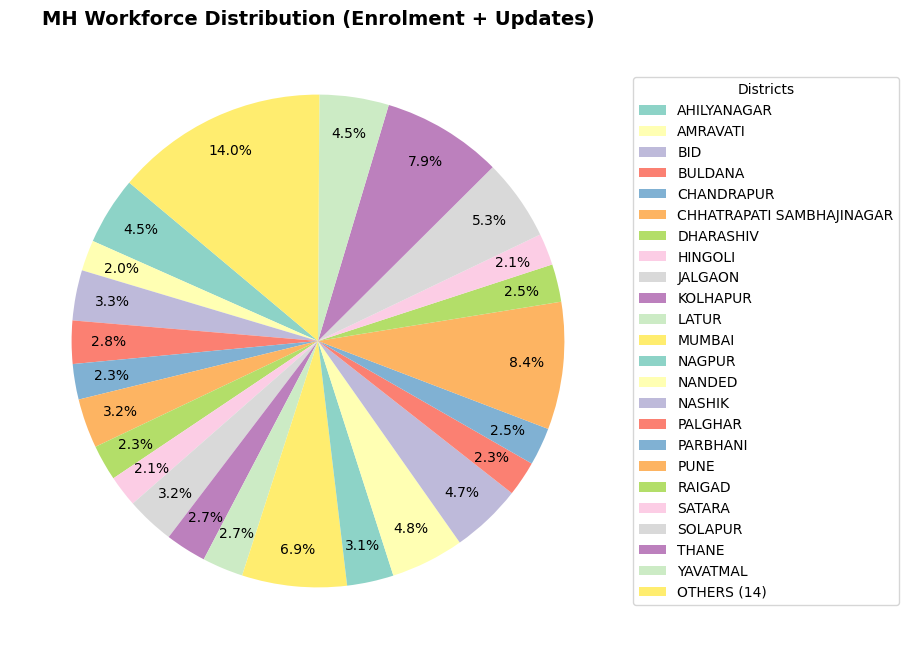

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
if 'df_mh' in locals():
    plt.figure(figsize=(10, 8))

    # Group small districts
    threshold = df_mh['Total_Workforce'].sum() * 0.02
    df_big = df_mh[df_mh['Total_Workforce'] >= threshold].copy()
    others_sum = df_mh[df_mh['Total_Workforce'] < threshold]['Total_Workforce'].sum()
    df_others = pd.DataFrame({'clean_dist': [f'OTHERS ({len(df_mh)-len(df_big)})'], 'Total_Workforce': [others_sum]})
    plot_pie = pd.concat([df_big[['clean_dist', 'Total_Workforce']], df_others])

    # Plot
    plt.pie(plot_pie['Total_Workforce'], labels=None, autopct='%1.1f%%',
            startangle=140, pctdistance=0.85, colors=sns.color_palette('Set3', len(plot_pie)))
    plt.legend(plot_pie['clean_dist'], title="Districts", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title('MH Workforce Distribution (Enrolment + Updates)', fontsize=14, fontweight='bold')
    plt.savefig('MH_Workforce_Pie.png', dpi=300)
    plt.show()

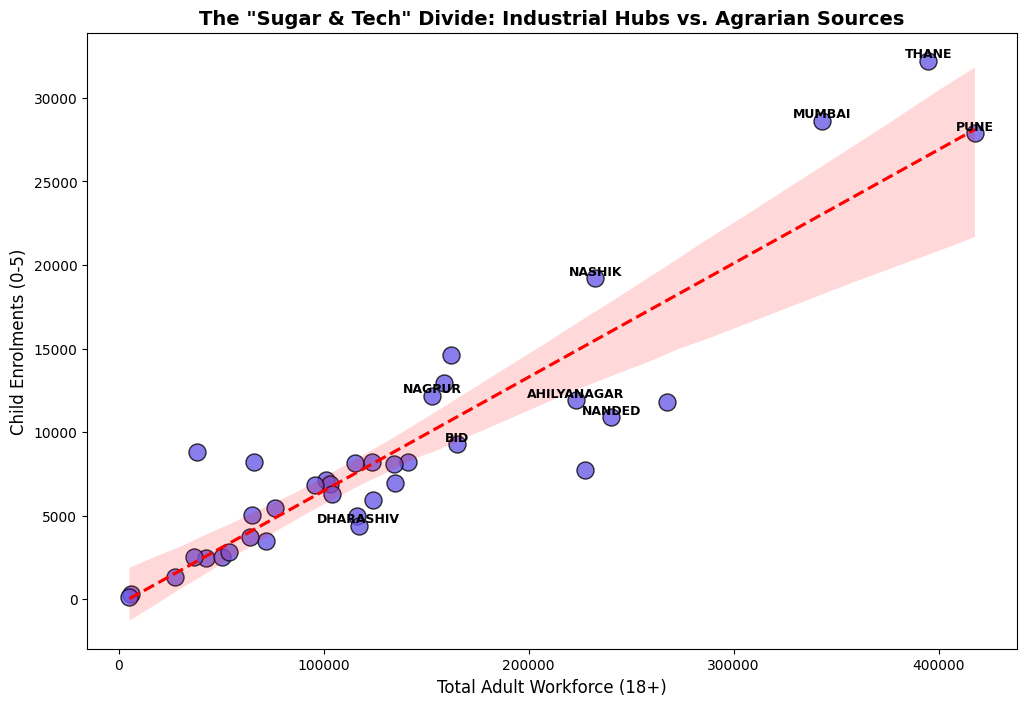

In [14]:
if 'df_mh' in locals():
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df_mh, x='Total_Workforce', y='Child_Enrolment', s=150, color='#6c5ce7', edgecolor='black', alpha=0.8)
    sns.regplot(data=df_mh, x='Total_Workforce', y='Child_Enrolment', scatter=False, color='red', line_kws={'linestyle':'--'})

    targets = ['MUMBAI', 'PUNE', 'THANE', 'NAGPUR', 'NASHIK', 'DHARASHIV', 'BID', 'NANDED', 'AHILYANAGAR']
    for t in targets:
        if t in df_mh['clean_dist'].values:
            row = df_mh[df_mh['clean_dist'] == t].iloc[0]
            plt.text(row['Total_Workforce'], row['Child_Enrolment'], t, fontsize=9, fontweight='bold', ha='center', va='bottom')

    plt.title('The "Sugar & Tech" Divide: Industrial Hubs vs. Agrarian Sources', fontsize=14, fontweight='bold')
    plt.xlabel('Total Adult Workforce (18+)', fontsize=12)
    plt.ylabel('Child Enrolments (0-5)', fontsize=12)
    plt.savefig('MH_Scatter_Divide.png', dpi=300)
    plt.show()

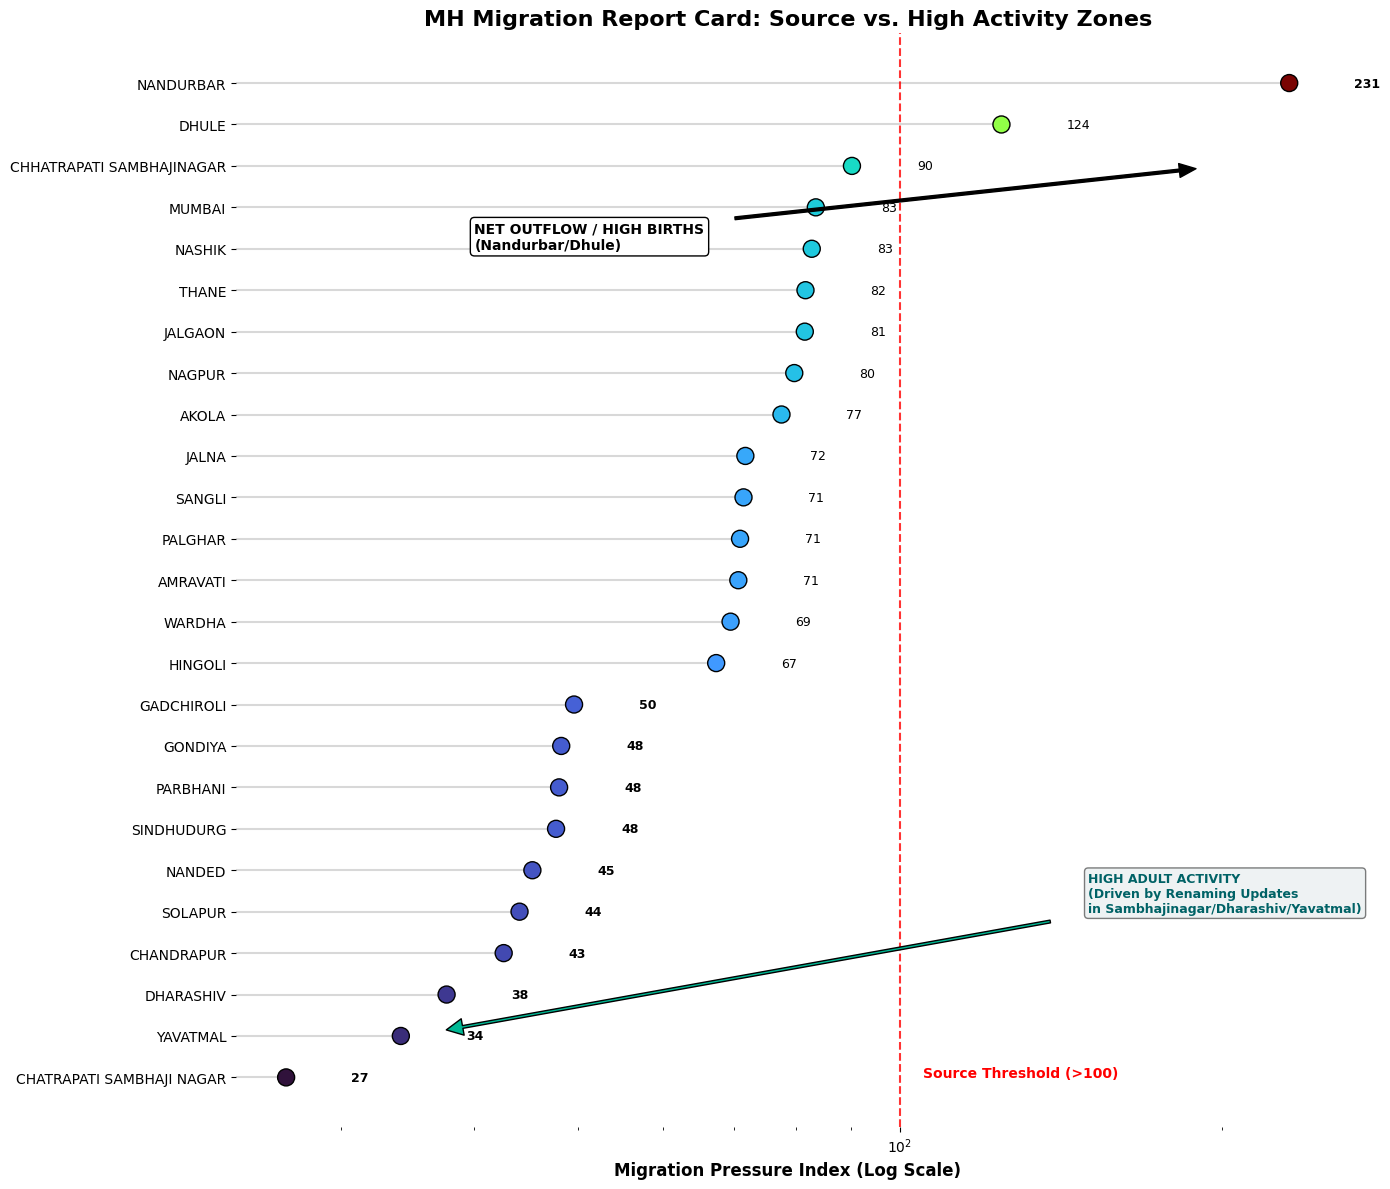

In [13]:
if 'df_mh' in locals():
    extra_fix = {
        'MUMBAI SUB URBAN': 'MUMBAI',
        'RAIGARHMH': 'RAIGAD',
        'CHHATRAPATI SAMBHAJI NAGAR': 'CHHATRAPATI SAMBHAJINAGAR',
        'NANDURBAR': 'NANDURBAR'
    }
    df_mh['clean_dist'] = df_mh['clean_dist'].replace(extra_fix)

    df_mh = df_mh.groupby('clean_dist')[['Child_Enrolment', 'Total_Workforce']].sum().reset_index()
    df_mh['Migration_Index'] = (df_mh['Child_Enrolment'] / (df_mh['Total_Workforce'] + 1)) * 1000

    df_sorted = df_mh.sort_values('Migration_Index', ascending=True).reset_index(drop=True)
    df_viz = pd.concat([df_sorted.head(10), df_sorted.tail(15)])

    plt.figure(figsize=(14, 12))

    norm = plt.Normalize(df_viz['Migration_Index'].min(), df_viz['Migration_Index'].max())
    colors = plt.cm.turbo(norm(df_viz['Migration_Index']))

    plt.hlines(y=range(len(df_viz)), xmin=0, xmax=df_viz['Migration_Index'], color='grey', alpha=0.3)
    plt.scatter(df_viz['Migration_Index'], range(len(df_viz)), c=colors, s=150, zorder=3, edgecolors='black')

    for i, row in df_viz.reset_index().iterrows():
        val = row['Migration_Index']
        weight = 'bold' if val > 150 or val < 50 else 'normal'
        plt.text(val * 1.15, i, f"{val:.0f}", va='center', fontsize=9, fontweight=weight, color='black')

    plt.axvline(x=100, color='red', linestyle='--', alpha=0.8)
    plt.text(105, 0, 'Source Threshold (>100)', color='red', fontsize=10, fontweight='bold')

    plt.annotate('HIGH ADULT ACTIVITY\n(Driven by Renaming Updates\nin Sambhajinagar/Dharashiv/Yavatmal)',
                 xy=(35, 1), xytext=(150, 4),
                 arrowprops=dict(facecolor='#00b894', shrink=0.05, width=2),
                 fontsize=9, fontweight='bold', color='#006266',
                 bbox=dict(boxstyle="round,pad=0.3", fc="#dfe6e9", alpha=0.5))

    plt.annotate('NET OUTFLOW / HIGH BIRTHS\n(Nandurbar/Dhule)',
                 xy=(200, 22), xytext=(40, 20),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=10),
                 fontsize=10, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))

    plt.yticks(range(len(df_viz)), df_viz['clean_dist'], fontsize=10)
    plt.xscale('log')
    plt.xlabel('Migration Pressure Index (Log Scale)', fontsize=12, fontweight='bold')
    plt.title('MH Migration Report Card: Source vs. High Activity Zones', fontsize=16, fontweight='bold')

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.savefig('MH_Migration_Ranking.png', dpi=300)
    plt.show()